In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from tqdm import trange
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
df = pd.read_csv('final_traj.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# split into training and test
train, test = train_test_split(df, test_size=0.2)

# train with KNN using TransportMode as target
X_train = train.drop('TransportMode', axis=1)
y_train = train['TransportMode']
X_test = test.drop('TransportMode', axis=1)
y_test = test['TransportMode']

In [66]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.net(x)

In [6]:
from sklearn.calibration import LabelEncoder

enc = LabelEncoder()
enc.fit(y_train.values.reshape(-1, 1))
enc_y_train = enc.transform(y_train.values.reshape(-1, 1))
enc.fit(y_test.values.reshape(-1, 1))
enc_y_test = enc.transform(y_test.values.reshape(-1, 1))

/home/sortur.n/.conda/envs/drqv2/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sortur.n/.conda/envs/drqv2/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
X_train_t = torch.tensor(X_train.values, dtype=torch.float32, requires_grad=True)[:X_train.shape[0] - X_train.shape[0] % 64, :]
y_train_t = torch.tensor(enc_y_train, dtype=torch.int64)[:enc_y_train.shape[0] - enc_y_train.shape[0] % 64]
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)[:X_test.shape[0] - X_test.shape[0] % 64, :]
y_test_t = torch.tensor(enc_y_test, dtype=torch.int64)[:enc_y_test.shape[0] - enc_y_test.shape[0] % 64]

train_tensords = torch.utils.data.TensorDataset(X_train_t, y_train_t)
test_tensords = torch.utils.data.TensorDataset(X_test_t, y_test_t)

## Get data loaders

In [54]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_tensords, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_tensords, batch_size=batch_size, shuffle=False, num_workers=True)

In [55]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        
        # ------------------
        # Write your implementation here.
        optimizer.zero_grad()
        ent_loss = torch.nn.CrossEntropyLoss()
        model_out = model(img)

        # target is 1 where ground truth is true
        loss = ent_loss(model_out, label)

        # optimize
        loss.backward()
        optimizer.step()
               
        # ------------------
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

In [34]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Write your implementation here.
            
            output = model(img)
            pred = torch.argmax(output, dim=1) # Get index of largest log-probability and use that as prediction
            
            ent_loss = torch.nn.CrossEntropyLoss()
            # get the number of correct predictions and append to num_correct
            num_correct += (pred == label).sum().item()
            test_loss += ent_loss(output, label)

            # ------------------
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [67]:
def train_mlp(hidden_units, lr, max_epochs):
    # Recording data
    log_interval = 100

    # Model initialization
    traj_nn = MLP(4, hidden_units, 11).to(DEVICE)

    # Instantiate optimizer (model was created in previous cell)
    optimizer = torch.optim.SGD(traj_nn.parameters(), lr=lr)

    train_losses = []
    train_counter = []
    test_losses = []
    test_correct = []
    for epoch in trange(max_epochs, leave=True, desc='Epochs'):
        train_loss, counter = train_one_epoch(train_loader, traj_nn, DEVICE, optimizer, log_interval, epoch)
        test_loss, num_correct = test_one_epoch(test_loader, traj_nn, DEVICE)

        # Record results
        train_losses.extend(train_loss)
        train_counter.extend(counter)
        test_losses.append(test_loss)
        test_correct.append(num_correct)
        print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")
    
    return train_losses, train_counter, test_losses, test_correct

In [69]:
trl_1, trc_1, tel_1, tec_1 = train_mlp(hidden_units=128, lr=0.01, max_epochs=2)
trl_2, trc_2, tel_2, tec_2 = train_mlp(hidden_units=128, lr=0.001, max_epochs=2)
trl_3, trc_3, tel_3, tec_3 = train_mlp(hidden_units=256, lr=0.01, max_epochs=2)
trl_4, trc_4, tel_4, tec_4 = train_mlp(hidden_units=256, lr=0.001, max_epochs=2)

Epochs:  50%|█████████████████████████████████████████████████████████                                                         | 1/2 [17:10<17:10, 1030.36s/it]

Test accuracy: 0.5363118036211699


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [34:51<00:00, 1045.74s/it]


Test accuracy: 0.49940372562674096


Epochs:  50%|█████████████████████████████████████████████████████████                                                         | 1/2 [17:46<17:46, 1066.44s/it]

Test accuracy: 0.47831215181058495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [35:21<00:00, 1060.76s/it]


Test accuracy: 0.5367252785515321


Epochs:  50%|█████████████████████████████████████████████████████████                                                         | 1/2 [17:06<17:06, 1026.88s/it]

Test accuracy: 0.4651418871866295


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [34:14<00:00, 1027.26s/it]


Test accuracy: 0.5085306406685237


Epochs:  50%|█████████████████████████████████████████████████████████                                                         | 1/2 [17:06<17:06, 1026.12s/it]

Test accuracy: 0.4424616991643454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [34:27<00:00, 1033.62s/it]

Test accuracy: 0.5468662952646239


286


Text(0.5, 1.0, 'Train loss, lr=0.01, hidden=128')

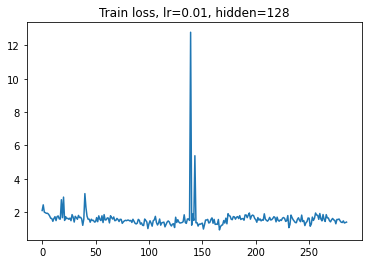

In [75]:
print(len(trl_1))
plt.plot(trl_1)
plt.title('Train loss, lr=0.01, hidden=128')

Text(0.5, 1.0, 'Train loss, lr=0.001, hidden=128')

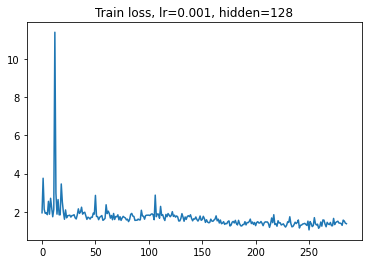

In [76]:
plt.plot(trl_2)
plt.title('Train loss, lr=0.001, hidden=128')

Text(0.5, 1.0, 'Train loss, lr=0.01, hidden=256')

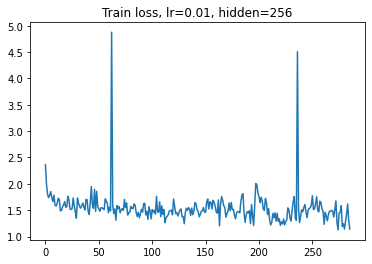

In [77]:
plt.plot(trl_3)
plt.title('Train loss, lr=0.01, hidden=256')

Text(0.5, 1.0, 'Train loss, lr=0.001, hidden=256')

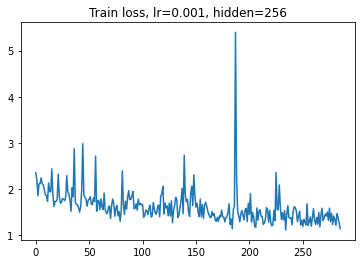

In [78]:
plt.plot(trl_4)
plt.title('Train loss, lr=0.001, hidden=256')